paper can be found here http://mmlab.ie.cuhk.edu.hk/projects/SRCNN.html

In [1]:
# check package versions
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('NumPy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Using TensorFlow backend.


Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Keras: 2.2.4
OpenCV: 4.1.0
NumPy: 1.16.2
Matplotlib: 3.0.3
Scikit-Image: 0.14.2


In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.measure import compare_ssim as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# python magic function, displays pyplot figures in the notebook
%matplotlib inline

In [3]:
# image quality metrics

# define a function for peak signal-to-noise ratio (PSNR)
# Higer the better
def psnr(target, ref):
         
    # assume RGB image
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# define function for mean squared error (MSE)
# Lower the error more similar to original image
def mse(target, ref):
    # the MSE between the two images is the sum of the squared difference between the two images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# ssim stands for Structural Similarity and we are importing it directly from skimage
# It tells how similar two images are. '1' being exactly similar

# define function that combines all three image quality metrics
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel =True))
    
    return scores


In [4]:
# prepare degraded images by introducing quality distortions via resizing

# 'factor' is the measure to which we will alter the image in 'path'
def prepare_images(path, factor):
    
    # loop through the files in the directory
    for file in os.listdir(path):
        
        # open the file
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = int( h / factor )
        new_width = int( w / factor )
        
        # resize the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('images/{}'.format(file), img)

In [5]:
# distorting the image
prepare_images('source/', 3)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving Capture.PNG
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


In [6]:
# test the generated images using the image quality metrics

for file in os.listdir('images/'):
    
    # open target and reference images
    target = cv2.imread('images/{}'.format(file))
    ref = cv2.imread('source/{}'.format(file))
    
    # calculate score
    scores = compare_images(target, ref)

    # print all three scores with new line characters (\n) 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 20.051808002302312
MSE: 1927.6173
SSIM: 0.5006928299822372

baby_GT.bmp
PSNR: 31.69723520103162
MSE: 131.97087478637695
SSIM: 0.8883361032967249

barbara.bmp
PSNR: 23.447393065729266
MSE: 881.9872540509259
SSIM: 0.73065294994638

bird_GT.bmp
PSNR: 29.79135363470666
MSE: 204.6756847993827
SSIM: 0.9128571831791062

butterfly_GT.bmp
PSNR: 22.006520728495104
MSE: 1228.9933776855469
SSIM: 0.797964951530857

Capture.PNG
PSNR: 33.01254575575141
MSE: 97.48707499740853
SSIM: 0.9901690583706705

coastguard.bmp
PSNR: 24.189445957446942
MSE: 743.4589942392677
SSIM: 0.6096745582108661

comic.bmp
PSNR: 21.16826542909264
MSE: 1490.6479002770084
SSIM: 0.7093499981550738

face.bmp
PSNR: 28.747257347129583
MSE: 260.3010265700483
SSIM: 0.7185510464651969

flowers.bmp
PSNR: 24.88592275321631
MSE: 633.2997845303868
SSIM: 0.7894223069949616

foreman.bmp
PSNR: 27.103603466719377
MSE: 380.05046559343435
SSIM: 0.8865113978857826

head_GT.bmp
PSNR: 29.4934009109717
MSE: 219.2105867346939
SSIM: 

In [7]:
# define the SRCNN model

# note that input_shape is (None, None, 1) which means it will work on image with ANY height or weight but needs 
# only one channel! This is also because SRCNN was trained on YCrCb color space in paper (srcnn trained on Y channel). So we have to convert 
# into that channel and feed it.

def model():
    
    # define model type
    SRCNN = Sequential()
    
    # add model layers
    SRCNN.add(Conv2D(filters=128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

https://github.com/MarkPrecursor/SRCNN-keras find precomputed weights in 3051crop_weight_200.h5 file

In [8]:
# define necessary image processing functions

# makes image width and height divisible by some scale
def modcrop(img, scale):
    tmpsz = img.shape     # temp size
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale) # ensures dimensions of image are divisible by certain scale
    img = img[0:sz[0], 1:sz[1]]
    return img


# cropping off border size
def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [9]:
# define main prediction function

def predict(image_path):
    
    # load the precomputed srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    # split directory name and path separaytely
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    # Y - Luminance
    # Cr - Red difference
    # Cb - Blue difference
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize between 0 and 1
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0] 
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

W0805 04:42:42.256129 16172 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 04:42:42.293123 16172 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 04:42:42.299963 16172 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 04:42:42.410383 16172 deprecation_wrapper.py:119] From E:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 04:42:42.471576 16172 deprecation_wrapper.py:119] From E:\ProgramData\Anac

Degraded Image: 
PSNR: 24.683754875846574
MSE: 663.4773906861002
SSIM: 0.7874282579320199

Reconstructed Image: 
PSNR: 24.719165242475214
MSE: 658.089696646522
SSIM: 0.7943586775093463



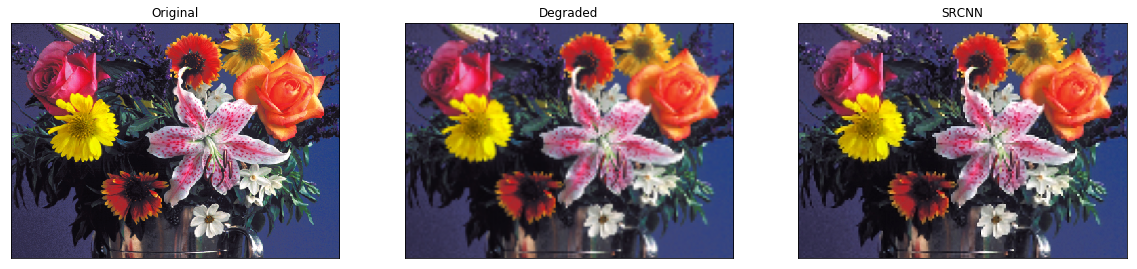

In [10]:
ref, degraded, output, scores = predict('images/flowers.bmp')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots

# rows=1 cols=3 (three images)  
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
# add specific images now

# First subplot - Convert BGR back to RGB as imshow accepts RGB not BGR
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')

# Second subplot
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')

# Third subplot
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
for file in os.listdir('images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    # os.path.splitext(file)[0] takes file name from [filename, extension] that was splitted
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    
    # saving recreated images
    # save the image
    print('Saving {} as a single image'.format(file))
    cv2.imwrite('recreated/{}.png'.format(os.path.splitext(file)[0]), output)
    
    plt.close()

Saving baboon.bmp
Saving baboon.bmp as a single image
Saving baby_GT.bmp
Saving baby_GT.bmp as a single image
Saving barbara.bmp
Saving barbara.bmp as a single image
Saving bird_GT.bmp
Saving bird_GT.bmp as a single image
Saving butterfly_GT.bmp
Saving butterfly_GT.bmp as a single image
Saving Capture.PNG
Saving Capture.PNG as a single image
Saving coastguard.bmp
Saving coastguard.bmp as a single image
Saving comic.bmp
Saving comic.bmp as a single image
Saving face.bmp
Saving face.bmp as a single image
Saving flowers.bmp
Saving flowers.bmp as a single image
Saving foreman.bmp
Saving foreman.bmp as a single image
Saving head_GT.bmp
Saving head_GT.bmp as a single image
Saving lenna.bmp
Saving lenna.bmp as a single image
